In [ ]:
# Analyse diff STAR HHV8 :
# install :

In [1]:
import os
import pandas as pd

count_dir = "./count_star"
output_matrix = "./count_star/gene_count_matrix_STAR.csv"

files = [f for f in os.listdir(count_dir) if f.endswith("_ReadsPerGene.out.tab")]
dfs = []

for file in files:
    sample_name = file.replace("_not_hg38_ReadsPerGene.out.tab", "")  
    path = os.path.join(count_dir, file)


    df = pd.read_csv(path, sep='\t', skiprows=1, header=None)


    if len(df.columns) < 2:
        logging.warning(f"Fichier {file} a seulement {len(df.columns)} colonnes → skip")
        continue

    # Geneid + dernier colonne = nmb de reads
    df.columns = ['Geneid'] + [f"col{i}" for i in range(1, len(df.columns))]
    df = df[['Geneid', df.columns[-1]]]
    df.columns = ['Geneid', sample_name]

    dfs.append(df.set_index('Geneid'))

combined_df = pd.concat(dfs, axis=1)

# rm les  "unassigned"
gene_mask = ~combined_df.index.str.contains("N_", na=True) & ~combined_df.index.str.contains("unassigned", na=True)
combined_df = combined_df[gene_mask]


combined_df.to_csv(output_matrix)
print(f"Matrice Done  : {output_matrix}")

Matrice Done  : ./count_star/gene_count_matrix_STAR.csv


In [8]:
#Charger les data et librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


matrix_path = "./count_star/gene_count_matrix_STAR.csv"
df_counts = pd.read_csv(matrix_path, index_col=0)

#print("Dimensions:", df_counts.shape)
df_counts.head()

,KAP_53_S11,KAP_74_S3,KAP_41_S2,KAP_40_S3,KAP_37_S1,KAP_65_2_S2,KAP38_S3,KAP_67_S5,KAP_42_1_S4,KAP_68_S9,...,KAPKEY21_S14,KAP_78_S7,KAP51_S5,KAP36_S2,KAP_72_S12,KAP32_S1,KAPKEY22_S15,KAP_45_S7,KAP_62_2_S1,KAP_56_S12
Geneid,,,,,,,,,,,,,,,,,,,,,
HHV8GK18_gp01,0,12,0,0,0,0,3,0,0,0,...,0,0,3,1,0,4,0,113,4,0
HHV8_gs01,0,0,0,0,12,0,2,0,0,0,...,0,0,407,24,0,13896,0,187,112,1
HHV8GK18_gp38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,0,2,0
HHV8GK18_gp39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HHV8GK18_gp62,0,0,0,1,0,0,1,0,0,0,...,0,0,83,0,0,51,0,2,5,0


Statistiques par échantillon


,Total Reads,Moyenne par gène,Médiane par gène
KAP_62_2_S1,61449,3413.833333,93.5
KAP32_S1,48918,2717.666667,76.0
KAP_63_S5,27976,1554.222222,44.0
KAP_45_S7,22586,1254.777778,16.5
KAP51_S5,18866,1048.111111,76.0
KAP38_S3,9569,531.611111,19.0
KAP_33_S1,5894,327.444444,5.5
KAP_37_S2,3372,187.333333,3.0
KAP_64_S6,3026,168.111111,4.0
KAP39_S4,2114,117.444444,3.5


/tmp/ipykernel_2246855/1838346039.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_reads_per_sample.index, y="Total Reads", data=total_reads_per_sample, palette="viridis")


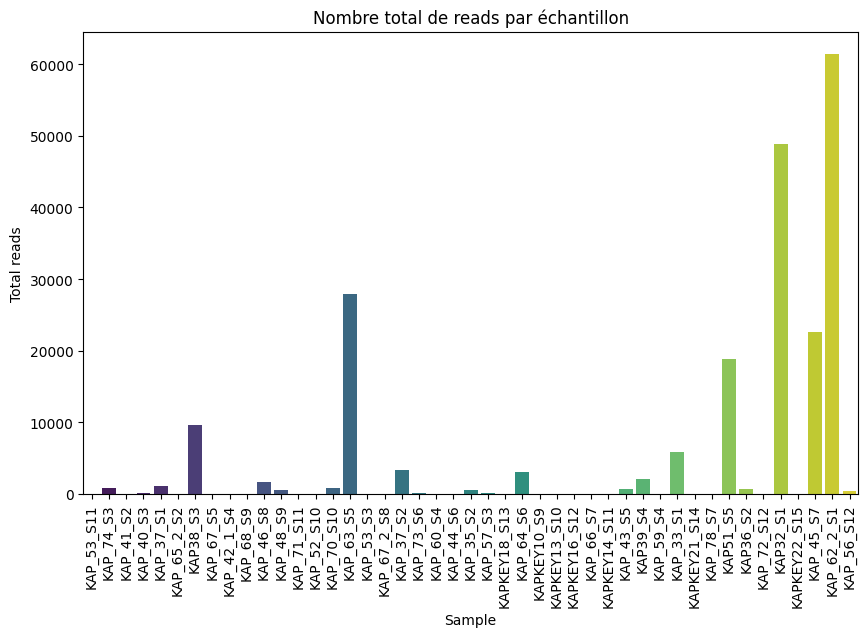

In [ ]:
#Tableau : Nombre total de reads par échantillon + Graphique

# total de reads par sample
total_reads_per_sample = df_counts.sum().to_frame(name="Total Reads")
total_reads_per_sample["Moyenne par gène"] = df_counts.mean()
total_reads_per_sample["Médiane par gène"] = df_counts.median()

print("Statistiques par échantillon")
display(total_reads_per_sample.sort_values(by="Total Reads", ascending=False))
#test modifiy os
# Histogramme
plt.figure(figsize=(10,6))
sns.barplot(x=total_reads_per_sample.index, y="Total Reads", data=total_reads_per_sample, palette="viridis")
plt.xticks(rotation=90)
plt.title("Nombre total de reads par échantillon")
plt.xlabel("Sample")
plt.ylabel("Total reads")
plt.show()

In [4]:
# Dictionnaire : identifiant → abréviation/fonction
gene_abbr = {
    "HHV8GK18_gp01": "K1",
    "HHV8_gs01": "miscRNA01",
    "HHV8GK18_gp39": "ORF35",
    "HHV8GK18_gp62": "vIRF-1 (K9)",
    "HHV8GK18_gp63": "vIRF-4",
    "HHV8GK18_gp64": "vIRF-3",
    "HHV8GK18_gp65": "vIRF-2",
    "HHV8GK18_gp79": "K12",
    "HHV8_gs02": "miscRNA02",
    "HHV8_gs03": "miscRNA03",
    "HHV8_gs04": "miscRNA04",
    "HHV8_gs05": "miscRNA05",
    "HHV8_gs06": "miscRNA06",
    "HHV8_gs07": "miscRNA07",
    "HHV8_gs08": "miscRNA08",
    "HHV8_gs09": "miscRNA09",
    "HHV8_gs10": "miscRNA10"
}

# Exemple d'utilisation : obtenir l'abréviation d'un gène 

#gene_ids = df_counts.index  # Utilise l'index du DataFrame comme liste des gènes
#for gene in gene_ids:
#    print(f"{gene} : {gene_abbr.get(gene, 'NA')}")


Gènes les plus exprimés :
Geneid
HHV8GK18_gp79    4204.933333
HHV8_gs01         341.244444
HHV8GK18_gp65      22.866667
HHV8_gs02          19.733333
HHV8GK18_gp64      16.444444
HHV8_gs06          16.000000
HHV8_gs03          15.733333
HHV8GK18_gp63      12.622222
HHV8_gs04          12.066667
HHV8_gs05          10.222222
dtype: float64

Heatmap des gènes les plus exprimés (top 20):


<Figure size 1000x800 with 0 Axes>

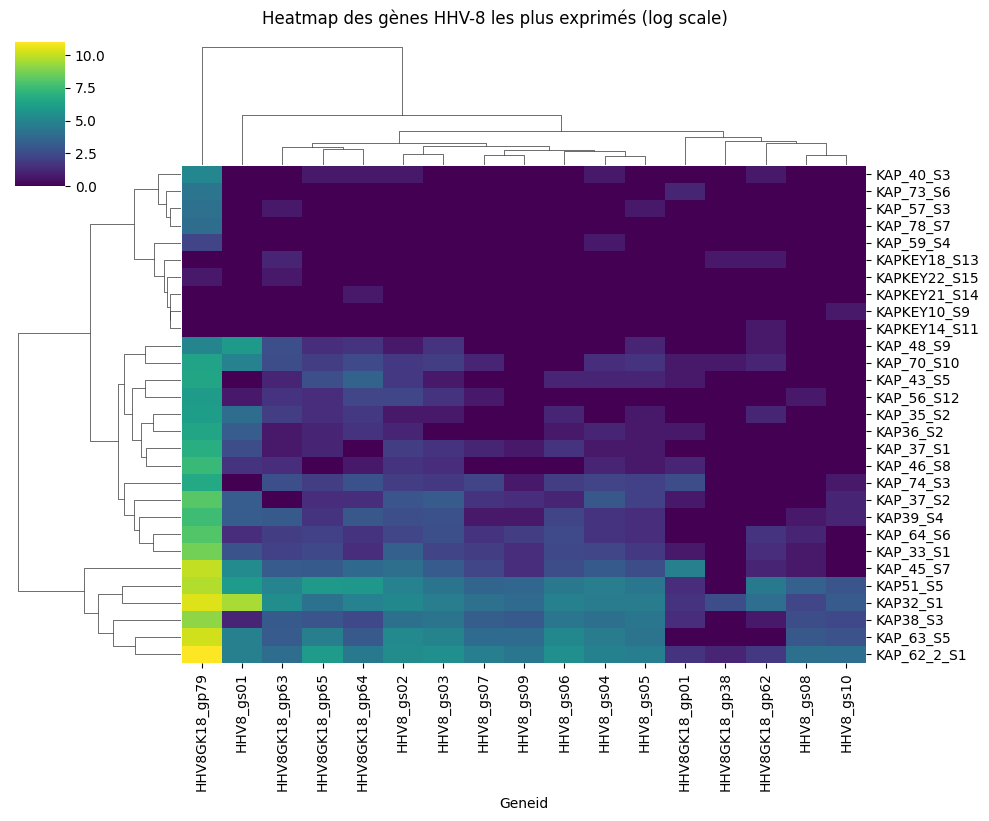


1 gènes sans expression :
['HHV8GK18_gp39']


In [5]:
# Moyenne d'expression par gène
mean_expression = df_counts.mean(axis=1).sort_values(ascending=False)
print("\nGènes les plus exprimés :")
print(mean_expression.head(10))

# plot :

df_filtered = df_counts.loc[:, df_counts.sum() > 0]  
df_gene_sorted = df_filtered.T 

top_genes = mean_expression[mean_expression > 0].head(20).index.tolist()
df_top_genes = df_gene_sorted[top_genes]

#heatmap
df_log = df_top_genes.apply(lambda x: np.log(x + 1))

plt.figure(figsize=(10, 8))
sns.clustermap(df_log, cmap="viridis", yticklabels=True, xticklabels=True, annot=False, figsize=(10, 8))
print("\nHeatmap des gènes les plus exprimés (top 20):")
plt.suptitle("Heatmap des gènes HHV-8 les plus exprimés (log scale)", y=1.02)
plt.show()

zero_genes = df_counts[df_counts.sum(axis=1) == 0].index.tolist()
print(f"\n{len(zero_genes)} gènes sans expression :")
print(zero_genes[:10])

In [ ]:
#Filtrage des gènes faiblement exprimés + Stats
# Filtrer les gènes exprimés dans au moins 2 échantillons avec > 10 reads
#threshold = 10
#min_samples = 2
#mask = (df_counts > threshold).sum(axis=1) >= min_samples
#filtered_df = df_counts[mask]

#print(f"🧬 Gènes avant filtrage : {df_counts.shape[0]}")
#print(f"🧬 Gènes après filtrage (>={min_samples} échantillons avec >{threshold} reads) : {filtered_df.shape[0]}")

# Exemple : Afficher quelques gènes filtrés
#print("\n🧬 Exemples de gènes conservés :")
#display(filtered_df.sample(5))

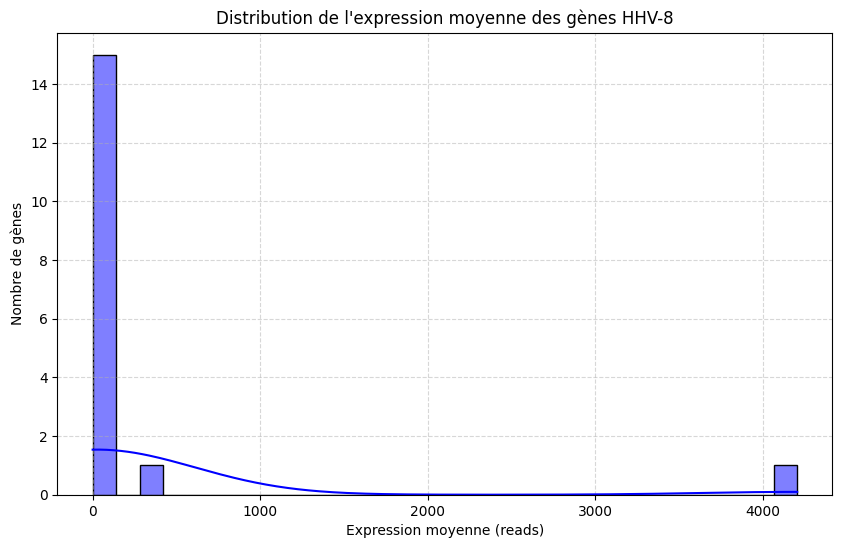

In [6]:
#Histogramme de l'expression moyenne des gènes
# Expression moyenne par gène
mean_expression = df_counts.mean(axis=1).sort_values(ascending=False)

mean_expression = mean_expression[mean_expression > 0]

# Histogramme
plt.figure(figsize=(10, 6))
sns.histplot(mean_expression, bins=30, kde=True, color='blue')
plt.xlabel("Expression moyenne (reads)")
plt.ylabel("Nombre de gènes")
plt.title("Distribution de l'expression moyenne des gènes HHV-8")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:

# Pour colorer les échantillons dans le graphe PCA, il faut une variable de groupe/catégorie.
# Exemple : on va colorer selon si le total de reads est > 1000 ou non (à adapter selon vos besoins)
group = total_reads_per_sample["Total Reads"] > 1000
group = group.map({True: "High", False: "Low"})

# PCA sur les données log-transformées pour une meilleure visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_df.T)

plt.figure(figsize=(10,8))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=group, palette="Set1", s=100, edgecolor="k")
for i, txt in enumerate(df_counts.columns):
    plt.annotate(txt, (pca_result[i,0], pca_result[i,1]), fontsize=8, alpha=0.7)
plt.title("PCA - Échantillons RNA-seq", fontsize=16)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
plt.legend(title="Total Reads", title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


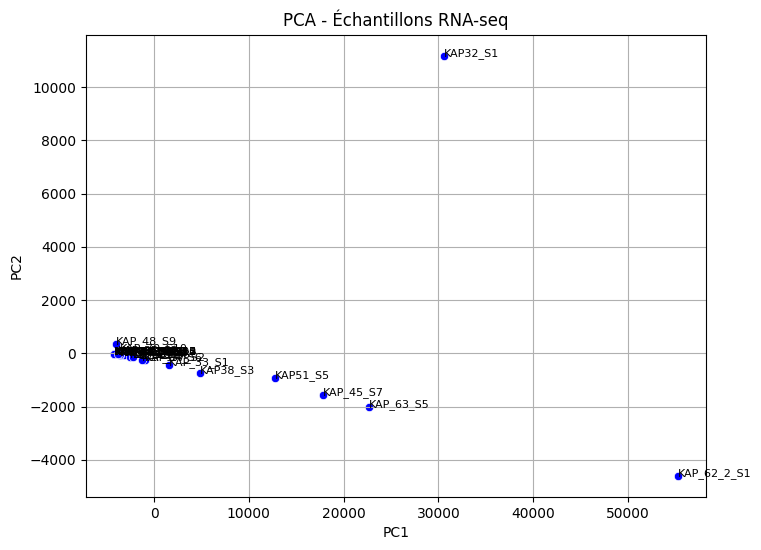

In [ ]:
from sklearn.decomposition import PCA
# Log transform
log_df = df_counts.apply(lambda x: np.log(x + 1))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_counts.T)

# Plot 
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],  color='blue')
for i, txt in enumerate(df_counts.columns):
    plt.annotate(txt, (pca_result[i,0], pca_result[i,1]),  fontsize=8)
plt.title("PCA - Échantillons RNA-seq")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()